# 🧠 Node Classification on a 300-node Subgraph (Amazon Computers)

This notebook performs node classification using a 2-layer GCN on a subgraph of 300 nodes from the Amazon Computers dataset.
It includes a side-by-side visualization of the network **without predictions** and **with predicted classes**.

In [6]:
# Define a simple 2-layer GCN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Amazon
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Load the Amazon Computers dataset
dataset = Amazon(root='data/Amazon', name='Computers')
data = dataset[0]

# Create a subgraph with a specified number of nodes (e.g., 300)
num_nodes_subgraph = 300
subgraph_nodes_indices = torch.arange(num_nodes_subgraph) # Select the first 300 nodes

# Filter nodes and edges to create the subgraph data object
sub_data = data.subgraph(subgraph_nodes_indices)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)

model = GCN(in_channels=sub_data.x.size(1), hidden_channels=32, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Processing...
Done!


In [7]:
# Define a simple 2-layer GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)

model = GCN(in_channels=sub_data.x.size(1), hidden_channels=32, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [8]:
# Train for all nodes (simple supervised)
for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    out = model(sub_data.x, sub_data.edge_index)
    loss = F.cross_entropy(out, sub_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Predict
model.eval()
pred = model(sub_data.x, sub_data.edge_index).argmax(dim=1)
accuracy = (pred == sub_data.y).sum().item() / sub_data.y.size(0)
print(f"Accuracy: {accuracy:.2f}")

Epoch 0, Loss: 2.4576
Epoch 20, Loss: 1.1500
Epoch 40, Loss: 0.7632
Epoch 60, Loss: 0.5685
Epoch 80, Loss: 0.4827
Epoch 100, Loss: 0.4071
Accuracy: 0.98


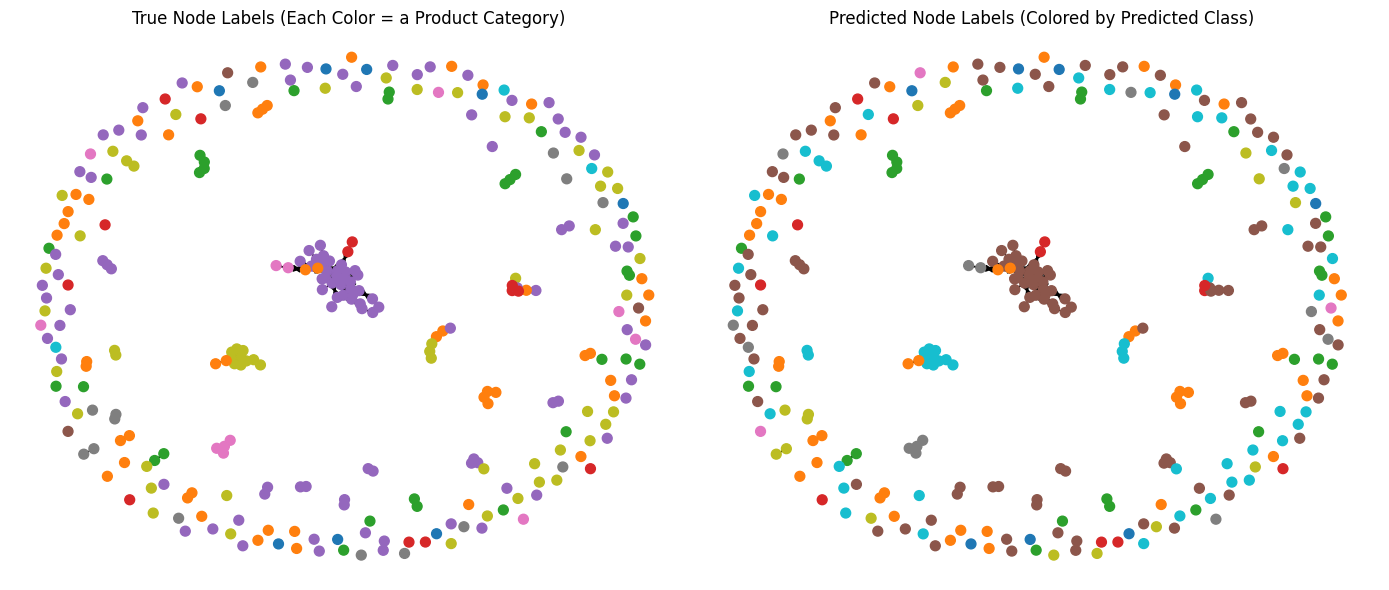

In [14]:
# Visualization: Left = true labels, Right = predictions
# Each color represents one product category (class index from 0 to 9)
# Pass the entire sub_data object to to_networkx
G = to_networkx(sub_data)
pos = nx.spring_layout(G, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# True labels
nx.draw(G, pos=pos, node_color=sub_data.y.tolist(), ax=axes[0], cmap='tab10', node_size=50)
axes[0].set_title("True Node Labels (Each Color = a Product Category)")

# Predicted labels
nx.draw(G, pos=pos, node_color=pred.tolist(), ax=axes[1], cmap='tab10', node_size=50)
axes[1].set_title("Predicted Node Labels (Colored by Predicted Class)")

plt.tight_layout()
plt.show()